In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib
rcParams.update({'figure.autolayout': True})
rcParams['svg.fonttype'] = 'none'
rcParams['font.size']=10

from keras.models import load_model

import pybedtools

Using Theano backend.
Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'/tmp/try_flags_swm6knmm.c:4:10: fatal error: cudnn.h: No such file or directory\n #include <cudnn.h>\n          ^~~~~~~~~\ncompilation terminated.\n'
Preallocating 10619/11178 Mb (0.950000) on cuda
Mapped name None to device cuda: GeForce GTX 1080 Ti (0000:1B:00.0)


In [2]:
colorsDict = {"Microglia":'#6b97ff',
              "Monocyte": '#ff6b97',
              "Neuron": '#97ff6b'}

In [3]:
microglia_regression = load_model("/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_gosselin_microglia/model_7.hdf5", compile = False)
monocyte_regression = load_model("/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_monocyte/model_8.hdf5", compile = False)
neuron_regression = load_model("/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_fullard_neun/model_2.hdf5", compile = False)

In [4]:
bulk_models_list = {"Microglia": microglia_regression,
                    "Monocyte": monocyte_regression,
                    "Neuron": neuron_regression}

In [5]:
rootPath = "/".join(["/projects",
                     "pfenninggroup",
                     "machineLearningForComputationalBiology",
                     "eramamur_stuff",
                     "ad_variants_processing",
                     "common_variants"])

In [6]:
scores_file_names = {"Microglia": "/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ad_variants_processing/rare_variants/gosselin_microglia_effect_scores.txt",
                     "Monocyte": "/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ad_variants_processing/rare_variants/encode_monocyte_effect_scores.txt",
                     "Neuron": "/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ad_variants_processing/rare_variants/fullard_put_neun_effect_scores.txt"
                    }

In [7]:
colnames = ["effect_score",
            "ref_score",
            "alt_score"
           ]

effect_score_standard_deviations = {}

for key in scores_file_names:
    scores = pd.read_csv(scores_file_names[key],
                         sep='\t',
                         names=colnames
                         )
    effect_score_standard_deviations[key] = np.std(scores["effect_score"])

In [8]:
region_bed = pybedtools.BedTool(os.path.join(rootPath,"alpk2_region_1_50kb.bed"))
cell_type_beds = {"Monocyte":pybedtools.BedTool(os.path.join("/projects",
                                                              "pfenninggroup",
                                                              "machineLearningForComputationalBiology",
                                                              "eramamur_stuff",
                                                              "gwas_enrichments",
                                                              "roadmap_dnase",
                                                              "encode_monocyte_dhs_optimal_peak_liftover_hg38_to_hg19.narrowPeak")),
                  "Microglia":pybedtools.BedTool(os.path.join("/projects",
                                                              "pfenninggroup",
                                                              "machineLearningForComputationalBiology",
                                                              "eramamur_stuff",
                                                              "gwas_enrichments",
                                                              "roadmap_dnase",
                                                              "gosselin_microglia_exvivo_idr_optimal_peak_liftover_hg38_to_hg19.narrowPeak")),
                  "Neuron":pybedtools.BedTool(os.path.join("/projects",
                                                           "pfenninggroup",
                                                           "machineLearningForComputationalBiology",
                                                           "eramamur_stuff",
                                                           "gwas_enrichments",
                                                           "roadmap_dnase",
                                                           "fullard_neun_put_idr_optimal_peak_liftover_hg38_to_hg19.narrowPeak"))}
    

In [9]:
region_chrom = region_bed[0][0]
region_start = int(region_bed[0][1])
region_end = int(region_bed[0][2])
region_length = region_end-region_start

In [10]:
ref_X = np.load(os.path.join(rootPath,"jansen_snps_intersecting_alpk2_region_1_50kb_reference_X.npy"))
alt_X = np.load(os.path.join(rootPath,"jansen_snps_intersecting_alpk2_region_1_50kb_alternate_X.npy"))
snp_info = pd.read_csv(os.path.join(rootPath,"jansen_snps_intersecting_alpk2_region_1_50k_hg19_alleles.txt"),
                            sep='\t',
                            header=None,
                            names=["CHR", "START", "END", "SNP", "REF", "ALT", "P", "Z"])

In [11]:
snp_info_bed = pybedtools.BedTool(os.path.join(rootPath,"jansen_snps_intersecting_alpk2_region_1_50k_hg19_alleles.txt"))

In [12]:
peaksIntersectingRegion = {}
for key in cell_type_beds:
    peaksIntersectingRegion[key] = pybedtools.bedtool.BedTool.intersect(cell_type_beds[key],
                                                              region_bed,
                                                              u=True
                                                             )

In [13]:
snpsIntersectingPeaks = {}
for key in cell_type_beds:
    snpsIntersectingPeaks[key] = pybedtools.bedtool.BedTool.intersect(snp_info_bed,
                                                                      cell_type_beds[key],
                                                                      c=True
                                                                     )

In [14]:
for key in bulk_models_list:
    model = bulk_models_list[key]
    intersecting_or_not = np.array([int(val[8]) > 0 for val in snpsIntersectingPeaks[key]])
    intersecting_or_not = np.reshape(intersecting_or_not, (intersecting_or_not.shape[0],1))
    ref_score = model.predict(ref_X)
    alt_score = model.predict(alt_X)
    effect_score = ref_score - alt_score
    effect_score_normed = effect_score/effect_score_standard_deviations[key]
    snp_info[key+"_intersecting"] = intersecting_or_not
    snp_info[key+"_ref_score"] = [ref_score[i,0] if intersecting_or_not[i,0] else None for i in range(len(ref_score))]
    snp_info[key+"_alt_score"] = [alt_score[i,0] if intersecting_or_not[i,0] else None for i in range(len(alt_score))]
    snp_info[key+"_effect_score"] = [effect_score[i,0] if intersecting_or_not[i,0] else None for i in range(len(effect_score))]
    snp_info[key+"_effect_score_normed"] = [effect_score_normed[i,0] if intersecting_or_not[i,0] else None for i in range(len(effect_score_normed))]

In [15]:
snp_info.loc[snp_info["Microglia_intersecting"]==True]

,CHR,START,END,SNP,REF,ALT,P,Z,Microglia_intersecting,Microglia_ref_score,...,Monocyte_intersecting,Monocyte_ref_score,Monocyte_alt_score,Monocyte_effect_score,Monocyte_effect_score_normed,Neuron_intersecting,Neuron_ref_score,Neuron_alt_score,Neuron_effect_score,Neuron_effect_score_normed
25,chr18,56168483,56168484,rs1806503,T,C,0.470454,0.721741,True,14.793844,...,True,5.527781,5.629924,-0.102142,-0.279906,False,NaN,NaN,NaN,NaN
26,chr18,56168540,56168541,rs12954360,G,C,0.962068,-0.047558,True,13.637029,...,True,5.801496,5.327352,0.474144,1.299322,False,NaN,NaN,NaN,NaN
32,chr18,56170249,56170250,rs72950969,C,T,0.365041,0.905802,True,17.708536,...,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
33,chr18,56170274,56170275,rs117974541,A,G,0.159875,1.405492,True,14.320203,...,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
109,chr18,56183488,56183489,rs72933243,G,A,0.359677,-0.915982,True,5.866472,...,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
110,chr18,56183559,56183560,rs74770545,C,T,0.010043,-2.574351,True,7.739357,...,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
111,chr18,56183625,56183626,rs182251428,C,A,0.976800,-0.029081,True,6.873891,...,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
112,chr18,56183748,56183749,rs59854784,C,T,0.341115,-0.951964,True,7.129230,...,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
114,chr18,56184106,56184107,rs3809985,C,T,0.035651,2.100884,True,6.828821,...,False,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
165,chr18,56197167,56197168,rs569712374,G,A,0.367000,-0.902107,True,17.613222,...,True,6.497257,5.708246,0.789011,2.162169,True,6.747387,4.151647,2.59574,5.738596


0 Monocyte
0.01666 0.02078
0.07724 0.08218
0.47546 0.48176
0.498 0.50284
0.56704 0.57434
0.57632 0.58404
0.65146 0.65704
0.75432 0.77012
0.78774 0.79412
0.8899 0.90536
0.8899 0.90536
0.95544 0.9614
1 Microglia
0.7551 0.76878
0.78676 0.79432
0.07612 0.08714
0.89704 0.90488
0.11222 0.11794
0.9549 0.96184
0.91038 0.91642
0.6519 0.65644
0.57472 0.58322
0.37966 0.38678
0.6519 0.65644
0.91038 0.91642
0.68186 0.68592
0.82962 0.8349
0.38806 0.39476
0.89114 0.89598
0.38806 0.39476
0.7551 0.76878
0.07612 0.08714
0.7551 0.76878
2 Neuron
0.65188 0.65578
0.1581 0.17112
0.1581 0.17112


/home/eramamur/bin/miniconda3/envs/gpu_keras_theano/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


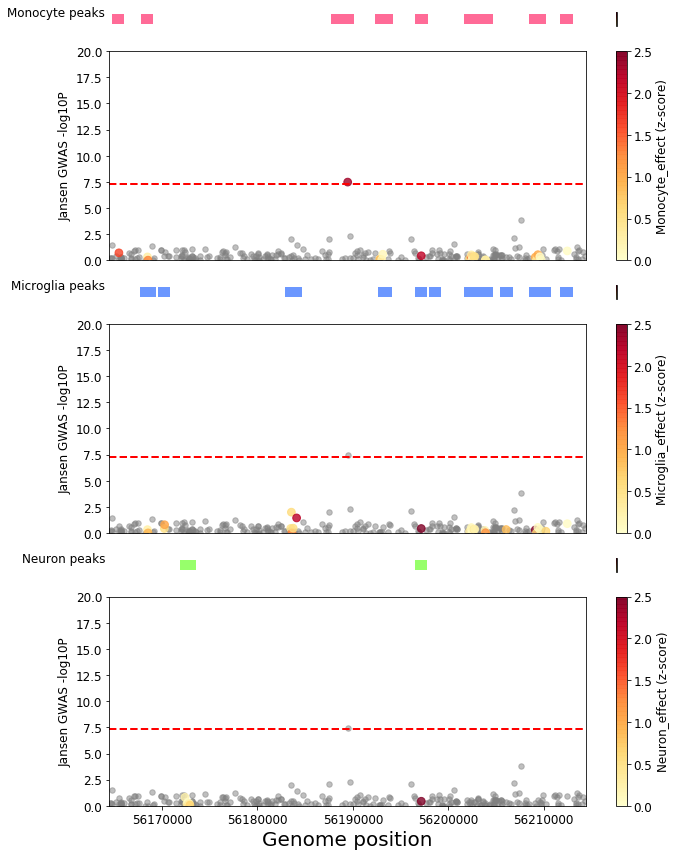

In [16]:
fig,axs = plt.subplots(6,1, figsize=(10,12), gridspec_kw={'height_ratios': [1,15,1,15,1,15]})


for i,key in enumerate(peaksIntersectingRegion):
    print(i,key)
    for interval in peaksIntersectingRegion[key]:
        interval_start = int(interval[1])
        interval_end = int(interval[2])
        plot_start = 1.0*(interval_start - region_start)/(region_length)
        plot_end = 1.0*(interval_end - region_start)/(region_length)
        plot_start = max(plot_start,0)
        plot_end = min(plot_end,1)
        print(plot_start, plot_end)
        axs[2*i].axhline(y=20,xmin=plot_start,xmax=plot_end, lw=10, c=colorsDict[key])
        axs[2*i].set_yticks([])
        axs[2*i].set_ylabel(key+" peaks",
                            rotation='horizontal',
                            horizontalalignment='right',
                            fontsize=12
                           )
        axs[2*i].spines['top'].set_visible(False)
        axs[2*i].spines['right'].set_visible(False)
        axs[2*i].spines['bottom'].set_visible(False)
        axs[2*i].spines['left'].set_visible(False)
        
    snp_info_na_snps = snp_info.loc[snp_info[key+"_intersecting"]==False]
    snp_info_scored_snps = snp_info.loc[snp_info[key+"_intersecting"]==True]

    im = axs[2*i+1].scatter(snp_info_na_snps["END"],
                    -np.log10(snp_info_na_snps["P"]),
                    c='gray',
                    alpha=0.5,
                    s=30,
                    rasterized=True)
    im = axs[2*i+1].scatter(snp_info_scored_snps["END"],
                    -np.log10(snp_info_scored_snps["P"]),
                    c=np.absolute(snp_info_scored_snps[key+"_effect_score_normed"]),
                    cmap="YlOrRd",
                    vmin=0,
                    vmax=2.5,
                    alpha=0.8,
                    s=60,
                    rasterized=True)

    axs[2*i+1].tick_params(axis='both', which='major', labelsize=12)
    axs[2*i+1].axhline(y=-np.log10(5e-8), linestyle='--', c='red', linewidth=2)
    axs[2*i+1].set_ylim([0,20])
    axs[2*i+1].set_xlim([region_start, region_end])
    axs[2*i+1].set_ylabel("Jansen GWAS -log10P", fontsize=12)
    cb = fig.colorbar(im,ax=axs[2*i+1], orientation='vertical')
    cb.ax.tick_params(labelsize=12)
    cb.set_label(key+"_effect (z-score)", fontsize=12)

    
    cb = fig.colorbar(im,ax=axs[2*i], orientation='vertical')
    cb.ax.tick_params(labelsize=12)
    cb.ax.axis("off")


for i in range(len(axs)-1):
    axs[i].set_xticks([])
axs[len(axs)-1].set_xlabel("Genome position",size=20)
axs[len(axs)-1].ticklabel_format(style='plain', useOffset=False)

        
plt.tight_layout()
plt.savefig("alpk2_bulk_model_scores.svg")

In [ ]:
#rs636317
#rs76726049

In [ ]:
snp_info.loc[snp_info["SNP"]=="rs636317"]